In [1]:
import matplotlib.pyplot as plt
import numpy as np
import imageio as io
import cv2
import pathlib
from pyometiff import OMETIFFReader
import imageio as io
from __future__ import print_function
import scanpy as sc
import os
import pandas as pd
import PIL
from tqdm.notebook import tqdm

### Put in the paths to the IF images as OME Tiffs and the xenium output folders for all the human IF stainings that you want to align

In [2]:
IF_paths = ['/mnt/sata1/Analysis_Alex/human_r1/IF_OMETIFF_human/hSI_05_r1_IF.ome.tif', '/mnt/sata1/Analysis_Alex/human_r1/IF_OMETIFF_human/hSI_05_r2_IF.ome.tif']

In [3]:
xen_paths = ['/mnt/sata1/Analysis_Alex/human_r1/human_05_r1/xenium_output', '/mnt/sata1/Analysis_Alex/human_r1/human_05_r2/xenium_output']

##### Perform the alignment which saves out the IF images

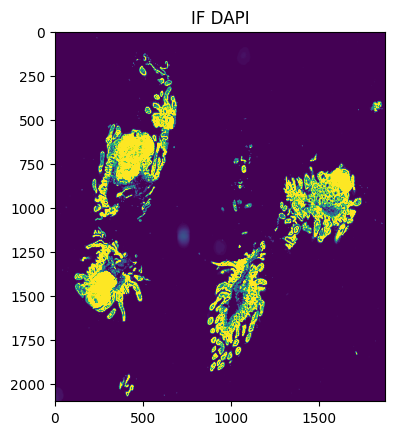

Key not found: 'NoneType' object has no attribute 'iter'
Key not found: 'NoneType' object has no attribute 'iter'


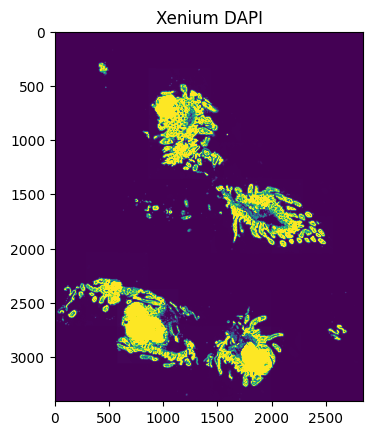

Aligning images ...
keypoint detection...
4000
4000
feature matching...
4000
prune bad matches...
2000
Estimated homography : 
 [[ 6.38473932e-03  1.53105401e+00 -5.09464575e+02]
 [-1.52950708e+00  8.29930552e-03  1.15297641e+04]
 [ 1.49704642e-07  1.85479216e-07  1.00000000e+00]]


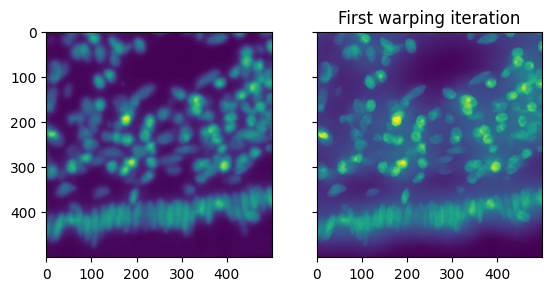

Starting final warp
Aligning images ...
keypoint detection...
4000
4000
feature matching...
4000
prune bad matches...
2000
warping


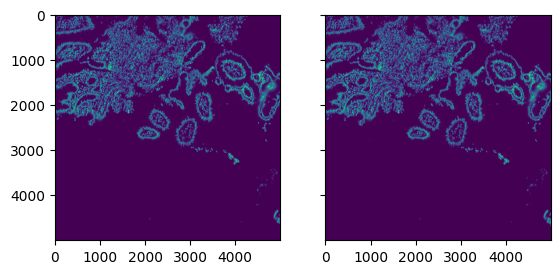

Channel 2 is not in this image


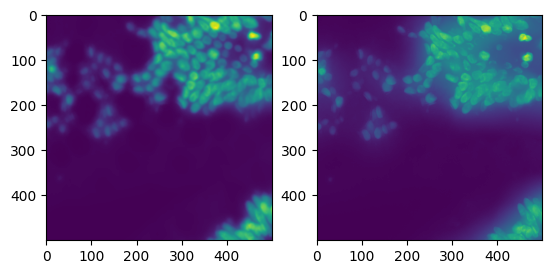

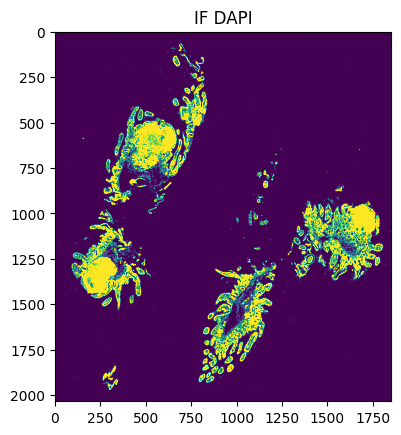

Key not found: 'NoneType' object has no attribute 'iter'
Key not found: 'NoneType' object has no attribute 'iter'


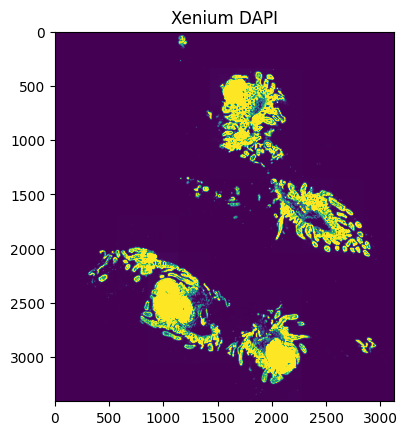

Aligning images ...
keypoint detection...
4000
4000
feature matching...
4000
prune bad matches...
2000
Estimated homography : 
 [[ 5.64889186e-03  1.52834085e+00  6.94670417e+02]
 [-1.52928059e+00  4.79675331e-03  1.13193037e+04]
 [ 7.75577192e-08 -9.87522313e-08  1.00000000e+00]]


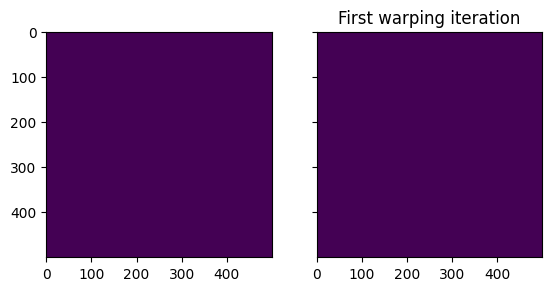

Starting final warp
Aligning images ...
keypoint detection...
3469
4000
feature matching...
3469
prune bad matches...
1734
warping


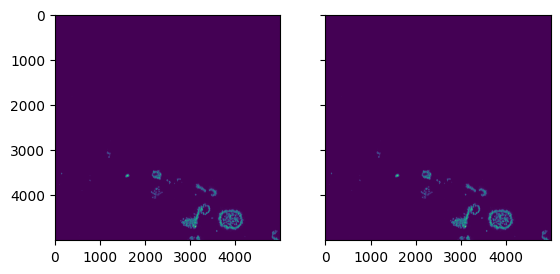

Channel 2 is not in this image


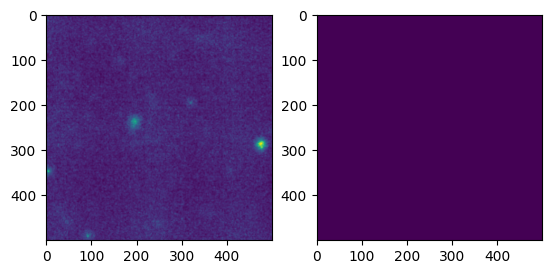

In [5]:
for k in range(len(IF_paths)):
    path_to_IF_ome = IF_paths[k]
    xenium_path = xen_paths[k]

    img_array_IF_orig = np.max(io.imread_v2(path_to_IF_ome), axis=0)

    channel_display = 0
    down_factor = 10

    new_width = int(img_array_IF_orig.shape[1] / down_factor)
    new_height = int(img_array_IF_orig.shape[2] / down_factor)
    # Normalize the image to the range [0, 1]
    normalized_image = img_array_IF_orig[channel_display, :, :] / np.max(img_array_IF_orig[channel_display, :,:])

    # Scale the values back to the range [0, 255] and convert to uint8
    normalized_image = (normalized_image * 255).astype(np.uint8)

    # Resize the image
    thumbnail = cv2.resize(normalized_image, (new_width, new_height))
    plt.imshow(thumbnail, vmax=np.percentile(thumbnail, 95))
    plt.title('IF DAPI')
    plt.show()
    plt.close()


    img_array_IF = normalized_image
    downscale_factor_IF = 3

    pad_height = (downscale_factor_IF - img_array_IF.shape[0] % downscale_factor_IF) % downscale_factor_IF
    pad_width = (downscale_factor_IF - img_array_IF.shape[1] % downscale_factor_IF) % downscale_factor_IF

    # Pad the array with zeros
    padded_IF = np.pad(img_array_IF, ((0, pad_height), (0, pad_width)), mode='constant')

    new_width = int(padded_IF.shape[1] / downscale_factor_IF)
    new_height = int(padded_IF.shape[0] / downscale_factor_IF)

    # Resize the image
    resized_image = cv2.resize(padded_IF, (new_width, new_height))
    IF_image = resized_image


    img_fpath = pathlib.Path(os.path.join(xenium_path, 'morphology_mip.ome.tif'))

    reader = OMETIFFReader(fpath=img_fpath)

    img_array_xenium, metadata_xenium, xml_metadata = reader.read()

    down_factor = 10

    new_width = int(img_array_xenium.shape[1] / down_factor)
    new_height = int(img_array_xenium.shape[0] / down_factor)

    # Resize the image
    thumbnail = cv2.resize(img_array_xenium, (new_width, new_height))
    plt.imshow(thumbnail, vmax=np.percentile(thumbnail, 95))
    plt.title('Xenium DAPI')
    plt.show()
    plt.close()

    downscale_factor = 3
    # Calculate the amount of padding needed for each axis
    pad_height = (downscale_factor - img_array_xenium.shape[0] % downscale_factor) % downscale_factor
    pad_width = (downscale_factor - img_array_xenium.shape[1] % downscale_factor) % downscale_factor

    # Pad the array with zeros
    padded_array = np.pad(img_array_xenium, ((0, pad_height), (0, pad_width)), mode='constant')

    # Now 'padded_array' will have both axes sizes divisible by 2
    img_array_xenium = padded_array

    new_width = int(img_array_xenium.shape[1] /downscale_factor) 
    new_height = int(img_array_xenium.shape[0] / downscale_factor)

    # Resize the image
    resized_xenium = cv2.resize(img_array_xenium, (new_width, new_height))


    #max number of corners to detect in each image
    MAX_FEATURES = 4000
    #percent of corner patches to keep
    GOOD_MATCH_PERCENT = 0.5
    #how much to blur the initial images to capture villi structure keypoints
    blur_res_IF = (1, 1)
    blur_res_xen = (1, 1)


    def alignImages(im1, im2):

        print('keypoint detection...')
        # Detect ORB features and compute descriptors.
        orb = cv2.ORB_create(MAX_FEATURES, patchSize= 100)
        keypoints1, descriptors1 = orb.detectAndCompute(im1, None)
        keypoints2, descriptors2 = orb.detectAndCompute(im2, None)
        print(len(keypoints1))
        print(len(keypoints2))
        print('feature matching...')
        # Match features.
        matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
        matches = matcher.match(descriptors1, descriptors2, None)
        matches = list(matches)
        print(len(matches))
        # Sort matches by score
        matches.sort(key=lambda x: x.distance, reverse=False)

        print('prune bad matches...')
        # Remove not so good matches
        numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
        matches = matches[:numGoodMatches]
        print(len(matches))
        # Draw top matches
        # imMatches = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches, None)
        # plt.figure(dpi=200)
        # plt.imshow(imMatches)
        # plt.show()
        # cv2.imwrite("matches.jpg", imMatches)

        # Extract location of good matches
        points1 = np.zeros((len(matches), 2), dtype=np.float32)
        points2 = np.zeros((len(matches), 2), dtype=np.float32)

        for i, match in enumerate(matches):
            points1[i, :] = keypoints1[match.queryIdx].pt
            points2[i, :] = keypoints2[match.trainIdx].pt

        # Find homography
        h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)

        # Use homography
        height, width = im2.shape
        im1Reg = cv2.warpPerspective(im1, h, (width, height))

        return im1Reg, h
    

    print("Aligning images ...")
    # Registered image will be resotred in imReg.
    # The estimated homography will be stored in h.
    imReg, h = alignImages(cv2.blur(((resized_image/np.max(resized_image))*255).astype(np.uint8), blur_res_IF), cv2.blur(((resized_xenium/np.max(resized_xenium))*255).astype(np.uint8), blur_res_xen))

    # Print estimated homography
    print("Estimated homography : \n",  h)

    height, width = resized_xenium.shape
    im1Reg = cv2.warpPerspective(resized_image, h, (width, height))

    new_width = int(im1Reg.shape[1] *downscale_factor_IF) 
    new_height = int(im1Reg.shape[0] *downscale_factor_IF)

    # Resize the image
    warped = cv2.resize(im1Reg, (new_width, new_height))

    %matplotlib inline
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
    ax1.imshow(warped[10000:10500, 10000:10500])
    ax2.imshow(img_array_xenium[10000:10500, 10000:10500])
    plt.title('First warping iteration')
    plt.show()

    print('Starting final warp')

    img_array_HE2 = normalized_image
    downscale_factor = 1

    pad_height = (downscale_factor - img_array_HE2.shape[0] % downscale_factor) % downscale_factor
    pad_width = (downscale_factor - img_array_HE2.shape[1] % downscale_factor) % downscale_factor

    # Pad the array with zeros
    padded_HE2 = np.pad(img_array_HE2, ((0, pad_height), (0, pad_width)), mode='constant')

    new_width = int(padded_HE2.shape[1] / downscale_factor)
    new_height = int(padded_HE2.shape[0] / downscale_factor)

    # Resize the image
    resized_image2 = cv2.resize(padded_HE2, (new_width, new_height))
    HE_image2 = resized_image2

    downscale_factor = 2
    # Calculate the amount of padding needed for each axis
    pad_height = (downscale_factor - warped.shape[0] % downscale_factor) % downscale_factor
    pad_width = (downscale_factor - warped.shape[1] % downscale_factor) % downscale_factor

    # Pad the array with zeros
    padded_array = np.pad(warped, ((0, pad_height), (0, pad_width)), mode='constant')

    # Now 'padded_array' will have both axes sizes divisible by 2
    warped = padded_array

    new_width = int(warped.shape[1] /downscale_factor) 
    new_height = int(warped.shape[0] / downscale_factor)

    # Resize the image
    resized_warped = cv2.resize(warped, (new_width, new_height))

    #max number of corners to detect in each image
    MAX_FEATURES = 4000
    #percent of corner patches to keep
    GOOD_MATCH_PERCENT = 0.5
    #how much to blur the initial images to capture villi structure keypoints
    blur_res = (5, 5)


    def alignImages(im1, im2):

        print('keypoint detection...')
        # Detect ORB features and compute descriptors.
        orb = cv2.ORB_create(MAX_FEATURES, patchSize= 100)
        keypoints1, descriptors1 = orb.detectAndCompute(im1, None)
        keypoints2, descriptors2 = orb.detectAndCompute(im2, None)
        print(len(keypoints1))
        print(len(keypoints2))
        print('feature matching...')
        # Match features.
        matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
        matches = matcher.match(descriptors1, descriptors2, None)
        matches = list(matches)
        print(len(matches))
        # Sort matches by score
        matches.sort(key=lambda x: x.distance, reverse=False)

        print('prune bad matches...')
        # Remove not so good matches
        numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
        matches = matches[:numGoodMatches]
        print(len(matches))
        # Draw top matches
        # imMatches = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches, None)
        # plt.figure(dpi=200)
        # plt.imshow(imMatches)
        # plt.show()
        #cv2.imwrite("matches.jpg", imMatches)

        # Extract location of good matches
        points1 = np.zeros((len(matches), 2), dtype=np.float32)
        points2 = np.zeros((len(matches), 2), dtype=np.float32)

        for i, match in enumerate(matches):
            points1[i, :] = keypoints1[match.queryIdx].pt
            points2[i, :] = keypoints2[match.trainIdx].pt

        # Find homography
        h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)

        print('warping')
        # Use homography
        height, width = im2.shape
        im1Reg = cv2.warpPerspective(im1, h, (width, height))

        return im1Reg, h
    

    print("Aligning images ...")
    # Registered image will be resotred in imReg.
    # The estimated homography will be stored in h.
    imReg, h = alignImages(cv2.blur(((resized_image2/np.max(resized_image2))*255).astype(np.uint8), blur_res)[:32766, :32766], resized_warped)

    height, width = warped.shape
    im1Reg = cv2.warpPerspective(resized_image2[:32766, :32766], h, (width, height))

    new_width = int(im1Reg.shape[1] *downscale_factor) 
    new_height = int(im1Reg.shape[0] *downscale_factor)

    # Resize the image
    warped2 = cv2.resize(im1Reg, (new_width, new_height))

    %matplotlib inline
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
    ax1.imshow(warped2[10000:15000, 10000:15000])
    ax2.imshow(warped[10000:15000, 10000:15000])
    plt.show()

    he_stack = []
    for i in [0, 1, 2]: 
        try:
            height, width = warped.shape
            im1Reg = cv2.warpPerspective(img_array_IF_orig[i,:,:][:32766, :32766], h, (width, height))

            new_width = int(im1Reg.shape[1] *downscale_factor) 
            new_height = int(im1Reg.shape[0] *downscale_factor)

            # Resize the image
            warped2 = cv2.resize(im1Reg, (new_width, new_height))
            warped_H_and_E = warped2[:np.shape(img_array_xenium)[0], :np.shape(img_array_xenium)[1]]
            he_stack.append(warped_H_and_E)
        except:
            print(f'Channel {i} is not in this image')

    transformed_h_and_e = np.dstack(he_stack)

    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(transformed_h_and_e[9500:10000, 9500:10000, 0])
    ax2.imshow(img_array_xenium[9500:10000, 9500:10000])
    plt.show()

    np.save(os.path.join(os.path.dirname(xenium_path), 'IF_alignment.npy'), transformed_h_and_e)